## Context

This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

## Content
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

userid: A unique number that identifies each player.
version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
retention_1: Did the player come back and play 1 day after installing?
retention_7: Did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kstest

import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [2]:
df = pd.read_csv('cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [3]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [4]:
duplicat_user_id = df['userid'].duplicated()
df[duplicat_user_id]

,userid,version,sum_gamerounds,retention_1,retention_7


In [5]:
control_group = df['version'] == 'gate_30'
variant_group = df['version'] == 'gate_40'
control_ids = df[control_group]['userid']
variant_ids = df[variant_group]['userid']
if control_ids.isin(variant_ids).any():
    print("Обнаружены userid из группы control, которые есть в группе variant:\n", control_ids[control_ids.isin(variant_ids)])
else:
    print("userid из группы control отсутствуют в группе variant.")

userid из группы control отсутствуют в группе variant.


493.0

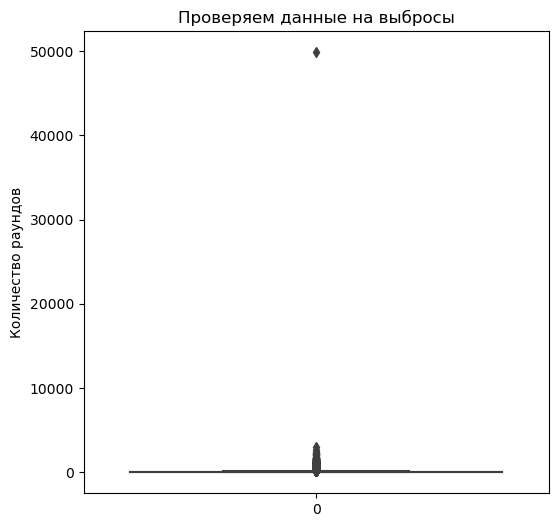

In [6]:
plt.figure(figsize=(6,6))
sns.boxplot(data=df['sum_gamerounds'])
plt.title('Проверяем данные на выбросы')
plt.ylabel('Количество раундов');
df['sum_gamerounds'].quantile(0.99)

Проводим сортировку фрейма и убираем самые вероятные выбросы и еще раз проверяем данные:

In [7]:
df = df.sort_values('sum_gamerounds')
df

,userid,version,sum_gamerounds,retention_1,retention_7
45094,4995815,gate_40,0,0,0
56753,6289435,gate_30,0,0,0
56786,6293240,gate_40,0,0,0
56834,6299092,gate_30,0,0,0
56876,6304159,gate_40,0,0,0
...,...,...,...,...,...
48188,5346171,gate_40,2294,1,1
43671,4832608,gate_30,2438,1,1
29417,3271615,gate_40,2640,1,0
7912,871500,gate_30,2961,1,1


In [8]:
df = df.drop(df[df['sum_gamerounds'] == 49854].index)
df.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44699.0,51.342111,102.057598,0.0,5.0,17.0,50.0,2961.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


In [9]:
df['retention_1'] = df['retention_1'].astype(bool)
df['retention_7'] = df['retention_7'].astype(bool)
df['sum_gamerounds'] = df['sum_gamerounds'].astype(np.uint16)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90188 entries, 45094 to 7912
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90188 non-null  int64 
 1   version         90188 non-null  object
 2   sum_gamerounds  90188 non-null  uint16
 3   retention_1     90188 non-null  bool  
 4   retention_7     90188 non-null  bool  
dtypes: bool(2), int64(1), object(1), uint16(1)
memory usage: 2.4+ MB


In [10]:
duplicat_row = df.duplicated()
df[duplicat_row]

,userid,version,sum_gamerounds,retention_1,retention_7


In [11]:
df_control= df[control_group]
df_test = df[variant_group]

In [12]:
mw_stats = mannwhitneyu(x=df_control['retention_1'].values,
                                                  y=df_test['retention_1'].values)
mw_stats

MannwhitneyuResult(statistic=1022670128.0, pvalue=0.073922385401239)

In [13]:
mw_stats7 = mannwhitneyu(x=df_control['retention_7'].values,
                                                  y=df_test['retention_7'].values)
mw_stats7

MannwhitneyuResult(statistic=1024975889.5, pvalue=0.0015918697815176374)

In [14]:
print(kstest(df_control['sum_gamerounds'], 'norm'))
print(kstest(df_test['sum_gamerounds'], 'norm'))

KstestResult(statistic=0.8724153079945488, pvalue=0.0)
KstestResult(statistic=0.8707186187388001, pvalue=0.0)


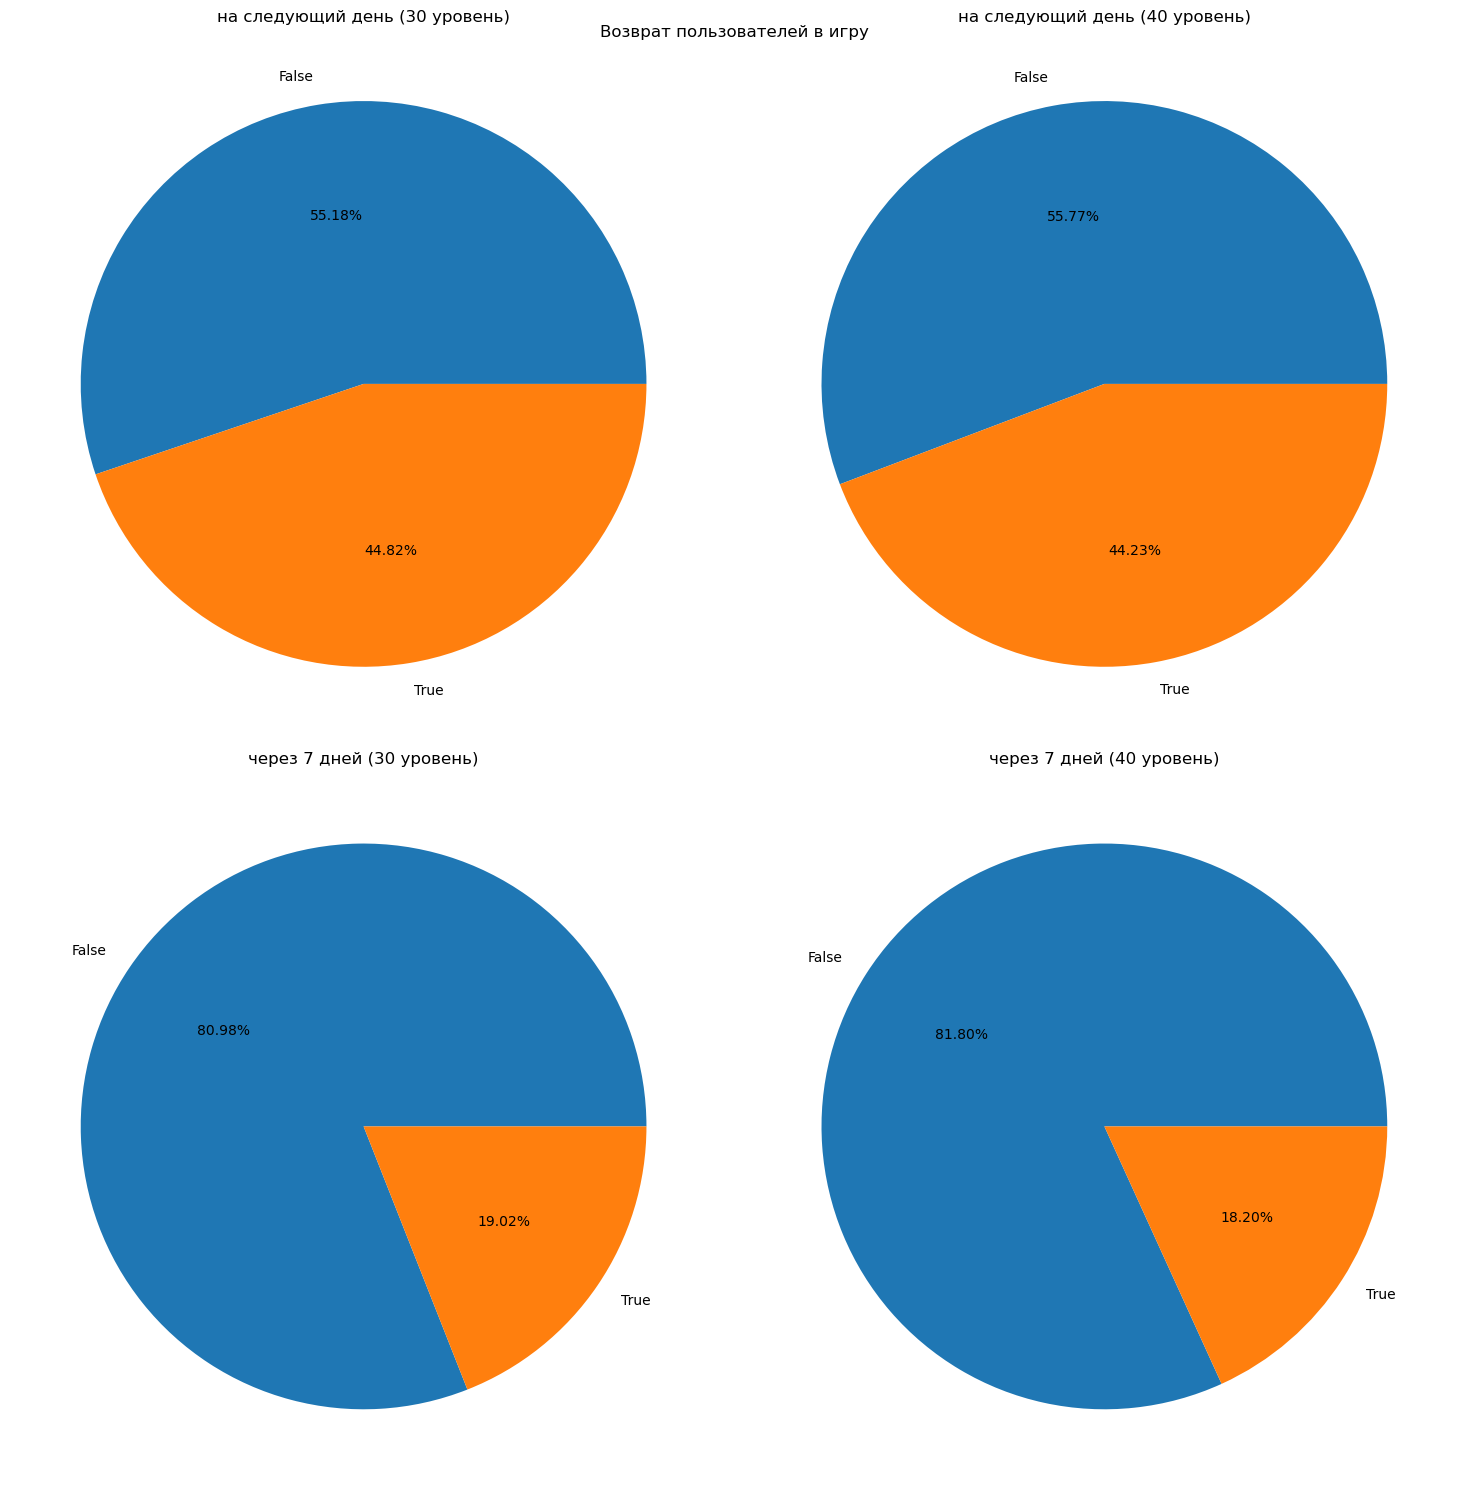

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
data = df_control['retention_1'].value_counts()
names = data.index
values = data.values
axs[0, 0].pie(values, autopct='%.2f%%', labels=names)
axs[0, 0].set_title('на следующий день (30 уровень)')
data1 = df_test['retention_1'].value_counts()
names = data1.index
values = data1.values
axs[0, 1].pie(values, autopct='%.2f%%', labels=names)
axs[0, 1].set_title('на следующий день (40 уровень)')
data2 = df_control['retention_7'].value_counts()
names = data2.index
values = data2.values
axs[1, 0].pie(values, autopct='%.2f%%', labels=names)
axs[1, 0].set_title('через 7 дней (30 уровень)');
data3 = df_test['retention_7'].value_counts()
names = data3.index
values = data3.values
axs[1, 1].pie(values, autopct='%.2f%%', labels=names)
axs[1, 1].set_title('через 7 дней (40 уровень)')
plt.tight_layout()
plt.suptitle('Возврат пользователей в игру')
plt.show();

In [16]:
b = bs.bootstrap_ab(df_control['sum_gamerounds'].values, df_test['sum_gamerounds'].values, stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference, alpha=0.05, num_iterations=10_000)

print(b.lower_bound, b.upper_bound)

-1.2986382768012654 1.3564280749643216


Судя по проведенному эксперименту наблюдается статистически значимая разница между показателями возврата пользователей в игру через 7 дней. Тестовая группа показала возврат на 0,82% ниже контрольной. В отношении показателй возврата пользователей в игру на следующий день статистически значимых различий нет, но на графике также видна отрицательная динамика в рамках данного эксперимента. В данных по количеству проведенных раундов между группами статистически значимых различий нет.
По данным результата эксперимента не рекомендую вводить данное обновление в игру в связи с отрицательным влиянием на возврат пользователей в игру через 7 дней.